# Titanic | Logistic Regression 

__In this notebook, we are going to build a Logistic Regression model using a training set of samples listing passengers who survived or did not survive the Titanic disaster. Then we check the performance of the model on a test dataset to evaluate how well the model is able to predict whether these passengers of the test dataset survived or not.__

### Let's get started:

## Step 1: Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import warnings

## Step 2: Read Datasets

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('gender_submission.csv')

## Step 3: Datasets Overview

__Training Dataset Overview:__

In [3]:
df_train.head(5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
df_train.shape

(891, 12)

__Test Dataset Overview:__

In [5]:
df_test.head(5)

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [6]:
df_test.shape

(418, 11)

__In order to prevent data leakage, we need to prepare each of the Training and Test datasets separately. But first of all we concatenate the actual target values from df_submission to the test dataset:__

In [7]:
df_test.insert(1,'Survived', df_submission['Survived'])

### Step 3.1: Datasets Basic Information:

__Training Dataset Basic Information:__

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


__Test Dataset Basic Information:__

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


### Step 3.2: Datasets Numerical Columns Description:

__Training Dataset Numerical Columns Description:__

In [10]:
df_train.describe(include='number')

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

__Test Dataset Numerical Columns Description:__

In [11]:
df_test.describe(include='number')

PassengerId    Survived      Pclass         Age       SibSp  \
count   418.000000  418.000000  418.000000  332.000000  418.000000   
mean   1100.500000    0.363636    2.265550   30.272590    0.447368   
std     120.810458    0.481622    0.841838   14.181209    0.896760   
min     892.000000    0.000000    1.000000    0.170000    0.000000   
25%     996.250000    0.000000    1.000000   21.000000    0.000000   
50%    1100.500000    0.000000    3.000000   27.000000    0.000000   
75%    1204.750000    1.000000    3.000000   39.000000    1.000000   
max    1309.000000    1.000000    3.000000   76.000000    8.000000   

            Parch        Fare  
count  418.000000  417.000000  
mean     0.392344   35.627188  
std      0.981429   55.907576  
min      0.000000    0.000000  
25%      0.000000    7.895800  
50%      0.000000   14.454200  
75%      0.000000   31.500000  
max      9.000000  512.329200

### Step 3.3: Datasets Object Columns Description:

__Training Dataset Object Columns Description:__

In [12]:
df_train.describe(include='object')

Name   Sex  Ticket    Cabin Embarked
count                       891   891     891      204      889
unique                      891     2     681      147        3
top     Braund, Mr. Owen Harris  male  347082  B96 B98        S
freq                          1   577       7        4      644

__Test Dataset Object Columns Description:__

In [13]:
df_test.describe(include='object')

Name   Sex    Ticket            Cabin Embarked
count                418   418       418               91      418
unique               418     2       363               76        3
top     Kelly, Mr. James  male  PC 17608  B57 B59 B63 B66        S
freq                   1   266         5                3      270

## Step 4: Deal with Missing Data in Training Dataset

__Next, we define a function that shows the distribution of missing values for each feature in the form of a graph. In this way, depending on the amount of missing values, we can decide how to deal with missing values in each feature:__

In [14]:
def plot_missing(df):
    '''
    This function shows distribution of missing values for all variables of the dataset in the form of a graph.
    '''
    plt.figure(figsize=(10, 4),dpi=80)
    sns.heatmap(df.isnull().transpose(), xticklabels=False, cbar=False, cmap='viridis')
    plt.title('Distribution of Missing Values among Variables', fontsize=20)
    plt.show()

### Step 4.1: Discover Missing Data in Training Dataset:

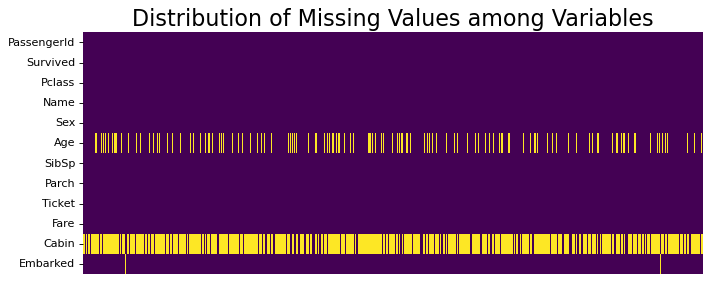

In [15]:
plot_missing(df_train)

In [16]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Step 4.2: Age Missing Data Imputation
__Next, we will try to complete Age feature according to other features:__

__We plot boxplots of Age versus the dataset categorical features. We also plot countplots of categorical features in parallel. We want to see that Age has different data distribution according to the categories of which of the features, so that we can use them to impute the missing data in Age:__

In [17]:
cat_features = ['Sex','Embarked','Pclass','SibSp','Parch']

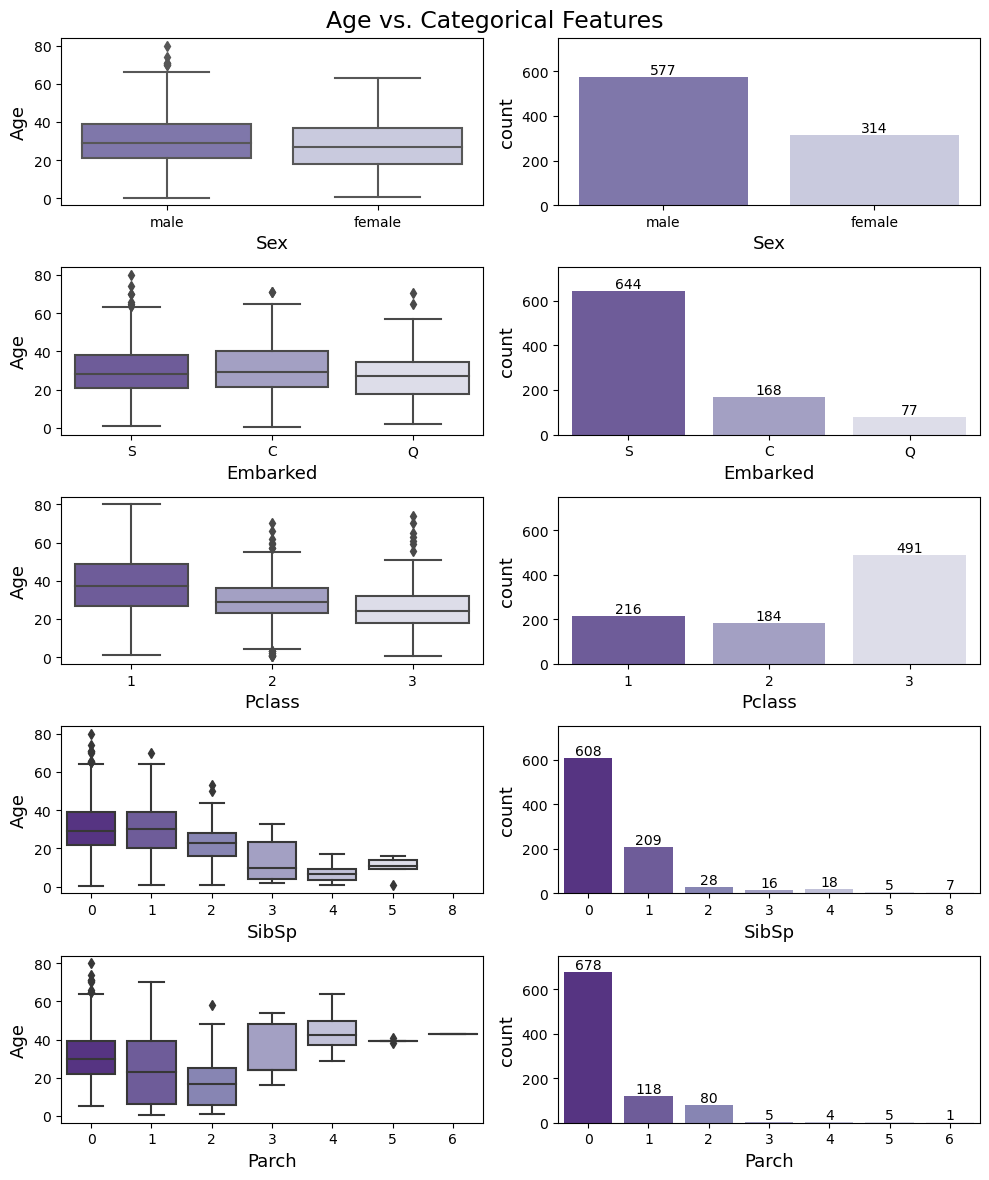

In [18]:
fig, ax = plt.subplots(5, 2, figsize=(10,12), dpi=100)

for idx, each_feature in enumerate(cat_features):
    # Plot Boxplot
    sns.boxplot(y='Age', x=each_feature, data=df_train, ax=ax[idx,0], palette='Purples_r')
    
    # Plot Countplot
    graph = sns.countplot(x=each_feature, data=df_train, ax=ax[idx,1], palette='Purples_r')
    ax[idx,1].set_ylim([0, 750])
    for cont in graph.containers:
        graph.bar_label(cont)
    
    # Set Axis Labels
    ax[idx,0].xaxis.label.set_size(13)
    ax[idx,0].yaxis.label.set_size(13)
    ax[idx,1].xaxis.label.set_size(13)
    ax[idx,1].yaxis.label.set_size(13)

plt.suptitle('Age vs. Categorical Features', fontsize=17)
plt.tight_layout()    
plt.show()

__From the graphs above, it can be seen that Age has a different median value according to the different categories of Pcalss. There is also a large amount of samples in each category of PCalss. It seems that the missing values in Age can be imputed according to the median value of those samples with the same Pclass category. To be sure, we also check the correlation of features with Age:__

In [19]:
age_corr = df_train.corr()['Age'].sort_values()
age_corr.drop('Age', inplace=True)
pd.DataFrame(age_corr.values, columns=['Correlation'], index=age_corr.keys())

Correlation
Pclass         -0.369226
SibSp          -0.308247
Parch          -0.189119
Survived       -0.077221
PassengerId     0.036847
Fare            0.096067

__As can be seen, Pclass has the largest absolute value of correlation with Age. Therefore, we made sure that we can impute the missing values in Age with the median value of Age of samples with the same Pclass category:__

In [20]:
df_train.groupby('Pclass')['Age'].median()

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

__Age Missing Data Imputation:__

In [21]:
df_train['Age'] = df_train.groupby('Pclass')['Age'].transform(lambda x : x.fillna(x.median()))

### Step 4.3: Embarked Missing Data Imputation

In [22]:
def missing_percent(df, col):
    '''
    This function calculates the percentage of missing values in a variable compared to the total number of samples.
    '''
    nan_percent = 100*(df[col].isnull().sum()/len(df))
    nan_percent = round(nan_percent,1)
    print('{}% of the data in {} are missing.'.format(nan_percent, col))

__The percentage of missing data in Embarked:__

In [23]:
missing_percent(df_train, 'Embarked')

0.2% of the data in Embarked are missing.


__Since the number of missing values in Embarked is very small compared to the total number of training dataset samples, we fill these missing values with the Mode value of Embarked (category with the highest frequency):__

In [24]:
df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [25]:
df_train['Embarked'].mode()

0    S
Name: Embarked, dtype: object

In [26]:
df_train['Embarked'].fillna(df_train['Embarked'].mode()[0] ,inplace=True)

### Step 4.4: Drop Cabin

__The percentage of missing data in Cabin:__

In [27]:
missing_percent(df_train, 'Cabin')

77.1% of the data in Cabin are missing.


__Most of the data of Cabin is missing. Therefore, this feature will not bring much information to the model and imputing it will bring a lot of noise. Therefore, we drop this feature:__

In [28]:
df_train.drop('Cabin', axis=1, inplace=True)

__Now, the training dataset is cleared of any missing data:__

In [29]:
df_train.isnull().sum().sum()

0

## Step 5: Deal with Missing Data in Test Dataset

### Step 5.1: Discover Missing Data in Test Dataset:

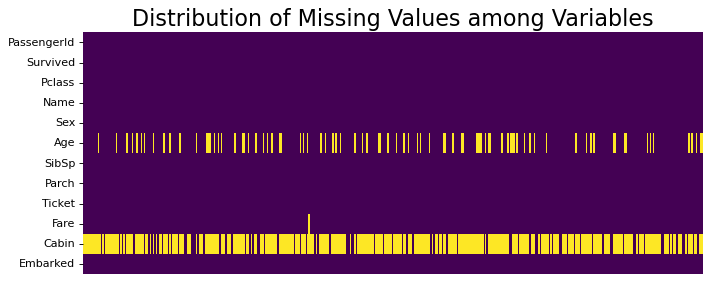

In [30]:
plot_missing(df_test)

### Step 5.2: Age Missing Data Imputation
__Similar to what was stated in training dataset cleaning, the missing values in Age again will be imputed according to the median of the age values of samples with the same Pcalss category:__

In [31]:
df_test['Age'] = df_test.groupby('Pclass')['Age'].transform(lambda x : x.fillna(x.median()))

### Step 5.3: Fare Missing Data Imputation

__The percentage of missing data in Fare:__

In [32]:
missing_percent(df_test, 'Fare')

0.2% of the data in Fare are missing.


__Since the number of missing values in Fare is very small compared to the total number of training dataset samples, we fill these missing values with the Median value of Fare:__

In [33]:
df_test['Fare'].median()

14.4542

In [34]:
df_test['Fare'].fillna(df_test['Fare'].median() ,inplace=True)

### Step 5.4: Drop Cabin

__The percentage of missing data in Cabin:__

In [35]:
missing_percent(df_test, 'Cabin')

78.2% of the data in Cabin are missing.


__Again most of the data of Cabin is missing. Therefore, we drop this feature from test dataset:__

In [36]:
df_test.drop('Cabin', axis=1, inplace=True)

__The test dataset was cleared of any missing data as well:__

In [37]:
df_test.isnull().sum().sum()

0

## Step 6: Feature Subset Selection

### Step 6.1: Drop PassengerId & Name
__Unique Values in PassengerId & Name:__

In [38]:
df_train['Name'].nunique()

891

In [39]:
df_train['PassengerId'].nunique()

891

__Number of Dataset Samples:__

In [40]:
len(df_train)

891

__As can be seen, values of PassengerId & Name features are all unique and therefore these features act as identifiers and lack valuable information for the model. So we drop them from both datasets:__

In [41]:
df_train.drop(['PassengerId', 'Name'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name'], axis=1, inplace=True)

### Step 6.2: Drop Ticket
__Let's check Ticket unique values:__

In [42]:
df_train['Ticket'].nunique()

681

__Since Ticket contains 681 unique values, and this number of values is very high compared to the number of dataset samples, it is better to drop this feature as well:__

In [43]:
df_train.drop('Ticket', axis=1, inplace=True)
df_test.drop('Ticket', axis=1, inplace=True)

## Step 7: EDA

### Step 7.1: Target vs. Categorical Features Bivariate Analysis

In [44]:
CatCols = ['Pclass','Sex','SibSp','Parch','Embarked']

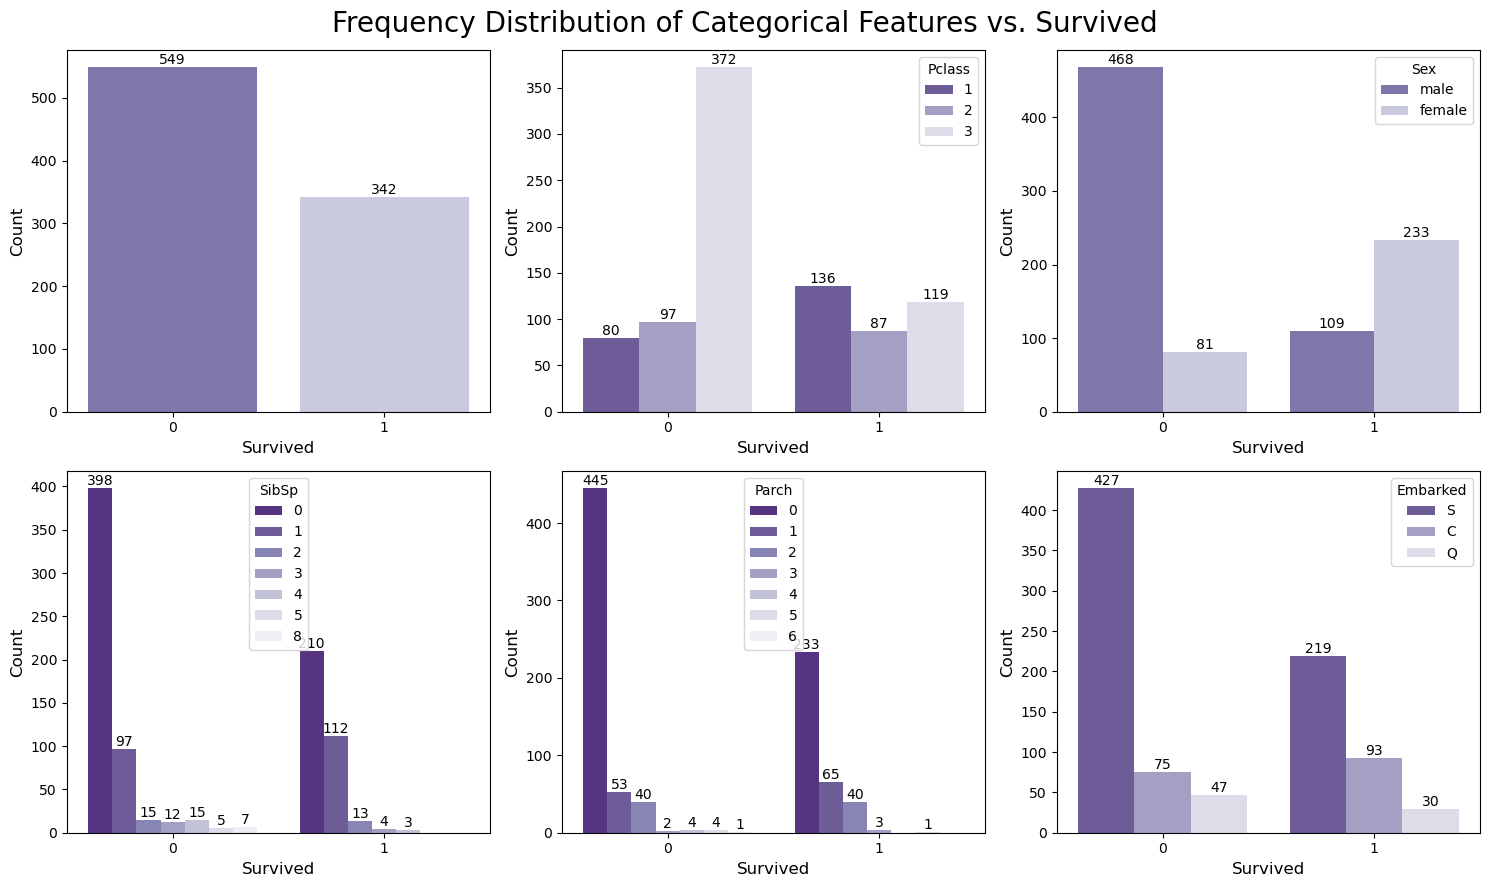

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,9), dpi=100)

# Target Countplot
graph_t = sns.countplot(x='Survived', data=df_train, ax=ax[0,0], palette='Purples_r')
ax[0,0].set_xlabel('Survived', fontsize=12)
ax[0,0].set_ylabel('Count', fontsize=12)
for cont in graph_t.containers:
    graph_t.bar_label(cont)    

# Frequency Distribution of Categorical Features vs. Survived
for i in range(1,len(CatCols)+1):
    x=i//3; y=i%3
    graph = sns.countplot(x='Survived', data=df_train, hue=CatCols[i-1], ax=ax[x,y], palette='Purples_r')
    ax[x,y].set_xlabel('Survived', fontsize=12)
    ax[x,y].set_ylabel('Count', fontsize=12)
    for cont in graph.containers:
        graph.bar_label(cont)
        
plt.suptitle('Frequency Distribution of Categorical Features vs. Survived', fontsize=20) 
plt.tight_layout()
plt.show()

__Conclusion:__
* __Due to the frequency of samples in both target classes, the dataset is almost balanced.__
* __Pclass & Sex play an important role in target estimation because the frequency of their categories has changed a lot with the change of the target class.__

### Step 7.2: Target vs. Numerical Features Bivariate Analysis

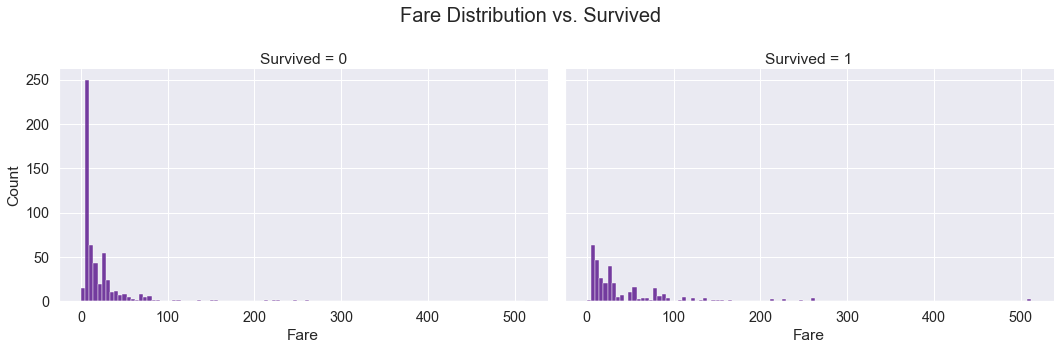

In [46]:
sns.set(font_scale=1.3)
plt.rcParams['patch.edgecolor'] = 'white'
sns.displot(x='Fare', data=df_train, col='Survived', color='indigo', height=5, aspect=1.5)
plt.suptitle('Fare Distribution vs. Survived', fontsize=20)
plt.tight_layout()
plt.show()

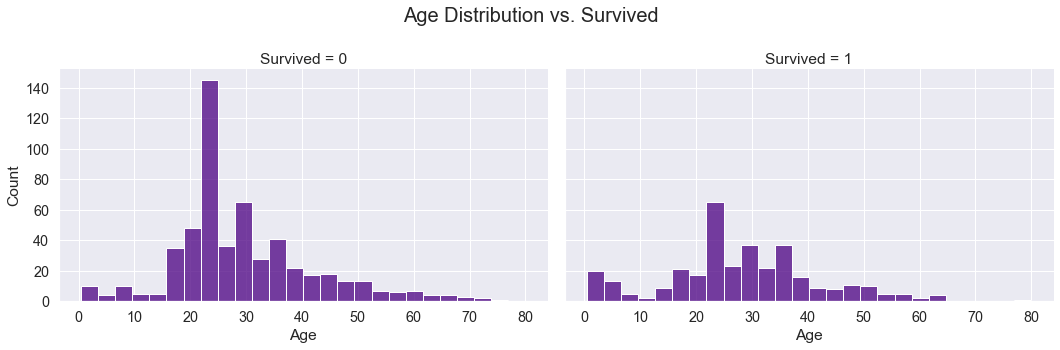

In [47]:
sns.displot(x='Age', data=df_train, col='Survived', color='indigo', height=5, aspect=1.5)
plt.suptitle('Age Distribution vs. Survived', fontsize=20)
plt.tight_layout()
plt.show()

__Conclusion:__
* __The distribution of Age & Fare is different by changing target classes, so they can be effective in estimating the target class.__

## Step 8: Categorical Features Encoding 
__Training Dataset Basic Information after Data Cleaning:__

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


__We implement dummy encoding on categorical columns:__

In [49]:
df_train['Pclass'] = df_train['Pclass'].apply(str)
df_test['Pclass'] = df_test['Pclass'].apply(str)

In [50]:
df_train = pd.get_dummies(df_train, columns=['Sex','Embarked','Pclass'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Sex','Embarked','Pclass'], drop_first=True)

__Training Dataset Basic Information after Dummy Encoding:__

In [51]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Age         891 non-null    float64
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   Sex_male    891 non-null    uint8  
 6   Embarked_Q  891 non-null    uint8  
 7   Embarked_S  891 non-null    uint8  
 8   Pclass_2    891 non-null    uint8  
 9   Pclass_3    891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 39.3 KB


__Test Dataset Basic Information after Dummy Encoding:__

In [52]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    418 non-null    int64  
 1   Age         418 non-null    float64
 2   SibSp       418 non-null    int64  
 3   Parch       418 non-null    int64  
 4   Fare        418 non-null    float64
 5   Sex_male    418 non-null    uint8  
 6   Embarked_Q  418 non-null    uint8  
 7   Embarked_S  418 non-null    uint8  
 8   Pclass_2    418 non-null    uint8  
 9   Pclass_3    418 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 18.5 KB


## Step 9: Correlation Analysis

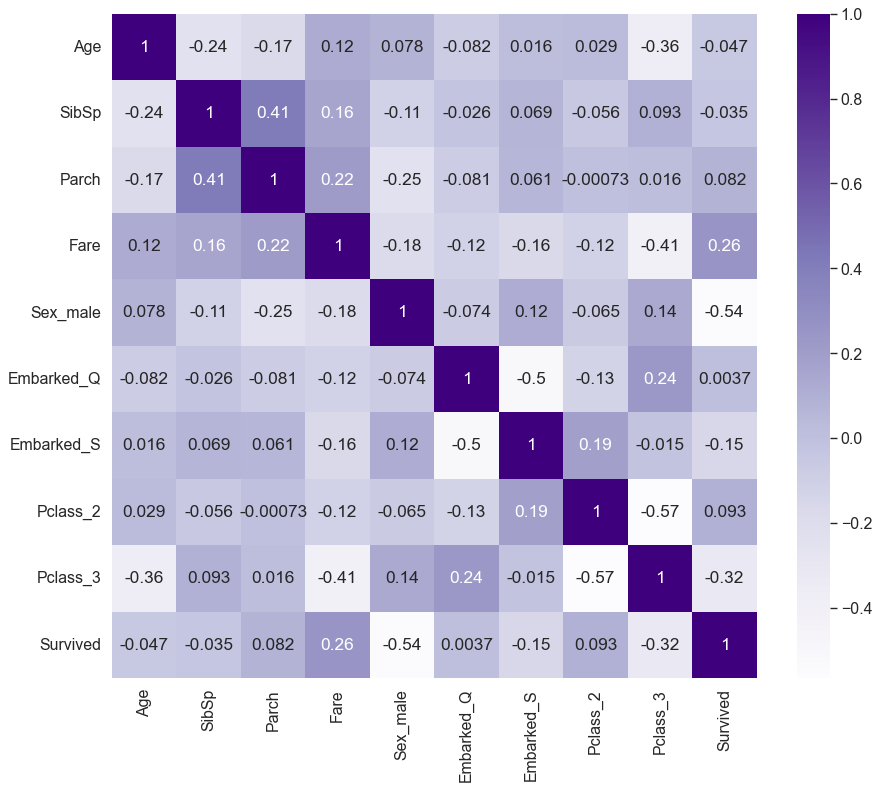

In [53]:
target = 'Survived'
fig, ax = plt.subplots(figsize=(13, 11), dpi=80)
corr = pd.concat([df_train.drop(target,axis=1), df_train[target]],axis=1).corr()
ax = sns.heatmap(corr, annot=True, cmap='Purples')
plt.show()

__Conclusion:__
* __Pcalss & Sex are the most important features in target estimation.__

## Step 10: Build Logistic Regression Model

### Step 10.1: Determine Features & Target Variables

In [54]:
X_train = df_train.drop('Survived', axis=1)
X_test = df_test.drop('Survived', axis=1)

y_train = df_train['Survived']
y_test = df_test['Survived']

In [55]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (891, 9)
X_test shape:  (418, 9)
y_train shape:  (891,)
y_test shape:  (418,)


### Step 10.2:  Train Logistic Regression Model

In [56]:
logistic_model = LogisticRegression(max_iter=500)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

## Step 11: Model Evaluation

### Step 11.1: Predict X-test

In [57]:
y_pred = logistic_model.predict(X_test)

### Step 11.2: Plot Confusion Matrix

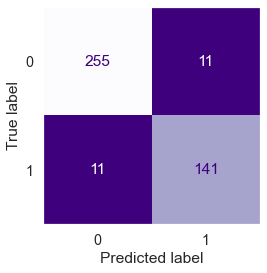

In [58]:
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test, y_test, colorbar=False, cmap='Purples_r')
plt.grid(False)

### Step 11.3: Classification Report

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       266
           1       0.93      0.93      0.93       152

    accuracy                           0.95       418
   macro avg       0.94      0.94      0.94       418
weighted avg       0.95      0.95      0.95       418



### Step 11.4: Calculate Performance Metrics

In [60]:
def metrics_calculator(y_test, y_pred, model_name):
    '''
    This function calculates all desired performance metrics for a given model.
    '''
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro')],
                          index=['Accuracy','Precision','Recall','F1-score'],
                          columns = [model_name])
    return result

__Base Model Performance Metrics:__

In [61]:
result = metrics_calculator(y_test, y_pred, 'Base Logistic')
result

Base Logistic
Accuracy        0.947368
Precision       0.943139
Recall          0.943139
F1-score        0.943139

### Step 11.5: Plot Curves

### Step 11.5.1: Plot Precision-Recall Curve

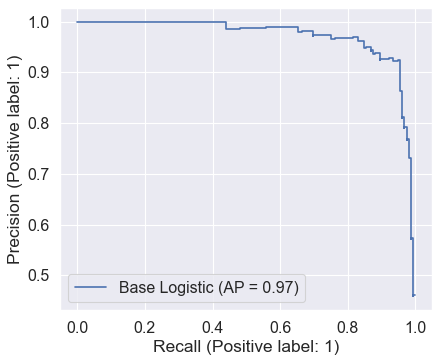

In [62]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=80)
PrecisionRecallDisplay.from_estimator(logistic_model, X_test, y_test, ax=ax, name='Base Logistic')
plt.show()

### Step 11.5.2: Plot ROC Curve

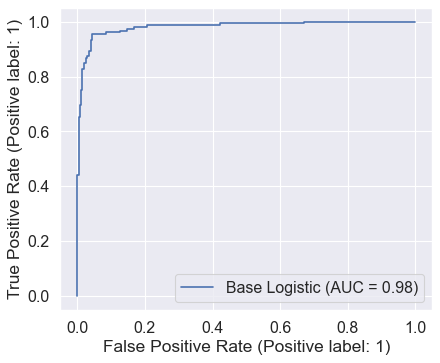

In [63]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=80)
RocCurveDisplay.from_estimator(logistic_model, X_test, y_test, ax=ax, name='Base Logistic')
plt.show()

## Step 12: Tune Logistic Regression Hyperparameters
__We try to find those hyperparameters values that are going to make our model boost out. It is possible to search the hyperparameter space for the best cross validation score using GridSearchCV. The grid search provided by GridSearchCV generates candidates from a grid of parameter values and choose the optimal values based on the desired metric:__

### Step 12.1: Define Base Estimator

In [64]:
log_reg = LogisticRegression()

### Step 12.2: Create Param Grid
__The choice of the solver depends on the penalty chosen. Supported penalties by solvers are:__

* __'lbfgs' -> ['l2', None]__

* __'liblinear' -> ['l1', 'l2']__

* __'newton-cg' -> ['l2', None]__

* __'sag' -> ['l2', None]__

* __'saga' -> ['elasticnet', 'l1', 'l2', None]__

__Therefore, different combinations of solver and penalty should be considered:__

In [65]:
param_grid = [{'solver':['lbfgs', 'newton-cg', 'sag', 'saga'], 'penalty':['none'], 'max_iter':[10000]},
              {'solver':['lbfgs', 'newton-cg', 'sag'], 'penalty':['l2'], 'C':np.logspace(-4, 4, 20), 'max_iter':[10000]},
              {'solver':['liblinear', 'saga'], 'penalty': ['l1', 'l2'], 'C':np.logspace(-4, 4, 20), 'max_iter':[10000]},
              {'solver':['saga'], 'penalty':['elasticnet'], 'C': np.logspace(-4, 4, 20), 'l1_ratio': np.arange(0,1.1,0.1), 'max_iter':[10000]}]    

### Step 12.3: Create Grid Search Object

In [66]:
logistic_grid = GridSearchCV(estimator =  log_reg,
                             param_grid = param_grid,
                             cv = StratifiedKFold(5, shuffle=True, random_state=0),
                             scoring = 'accuracy',
                             n_jobs = -1,
                             verbose = 1)

__We considered a Stratified 5-Folds Cross-validator for finding the optimal hyperparameters.__

### Step 12.4: Fit Grid Search Object on Training Data

In [67]:
warnings.simplefilter(action='ignore')

In [68]:
logistic_grid.fit(X_train, y_train)

Fitting 5 folds for each of 364 candidates, totalling 1820 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'max_iter': [10000], 'penalty': ['none'],
                          'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
                         {'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.3357214...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                          'max_iter': [10000], 'penalty': ['elasticnet'],
                          'solver': ['saga']}],
             scoring='

### Step 12.5: Choose Best Estimator Hyperparameters

In [69]:
logistic_grid.best_estimator_.get_params()

{'C': 0.615848211066026,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## Step 13: Final Model Evaluation

### Step 13.1: Predict X-test

In [70]:
y_pred_final = logistic_grid.predict(X_test)

### Step 13.2: Plot Final Model Confusion Matrix

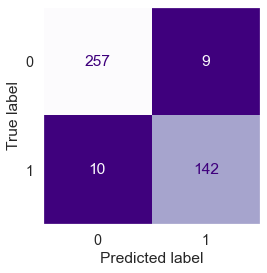

In [71]:
ConfusionMatrixDisplay.from_estimator(logistic_grid, X_test, y_test, colorbar=False, cmap='Purples_r')
plt.grid(False)

### Step 13.3: Final Model Classification Report

In [72]:
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       266
           1       0.94      0.93      0.94       152

    accuracy                           0.95       418
   macro avg       0.95      0.95      0.95       418
weighted avg       0.95      0.95      0.95       418



### Step 13.4: Determine Final Model Performance Metrics

In [73]:
final_result = metrics_calculator(y_test, y_pred_final, 'Final Logistic')
final_result

Final Logistic
Accuracy         0.954545
Precision        0.951472
Recall           0.950188
F1-score         0.950823

### Step 13.5: Plot Final Model Curves

### Step 13.5.1: Plot Final Model Precision-Recall Curve

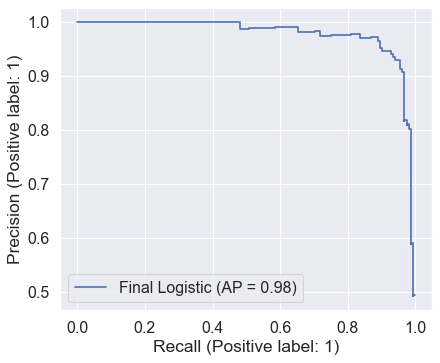

In [74]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=80)
PrecisionRecallDisplay.from_estimator(logistic_grid, X_test, y_test, ax=ax, name='Final Logistic')
plt.show()

### Step 13.5.2: Plot Final Model ROC Curve

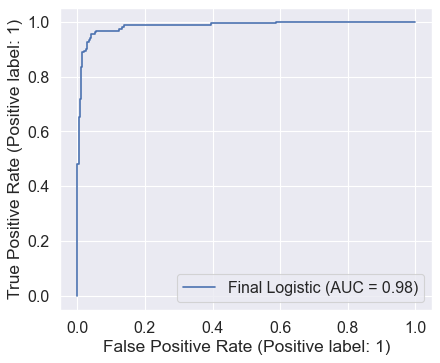

In [75]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=80)
RocCurveDisplay.from_estimator(logistic_grid, X_test, y_test, ax=ax, name='Final Logistic')
plt.show()

## Step 14: Conclusion
__Comparison of the Base Model to the Final Model:__

In [76]:
pd.concat([result, final_result], axis=1)

Base Logistic  Final Logistic
Accuracy        0.947368        0.954545
Precision       0.943139        0.951472
Recall          0.943139        0.950188
F1-score        0.943139        0.950823

__As can be seen, the performance of the model improves after tuning the hyperparameters.__

## Step 15: Submit Predicted Data

In [77]:
submission = pd.DataFrame()
submission['PassengerId'] = df_submission['PassengerId']
submission['Survived'] = y_pred_final
submission.to_csv('Logistic_Submission.csv',index=False)